In [1]:
from scipy.io import loadmat
from scipy import stats


import mat73

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import ssm

/Users/user/anaconda3/envs/main/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")


# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):

    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -13363.3: 100%|██████████| 100/100 [00:02<00:00, 44.68it/s]


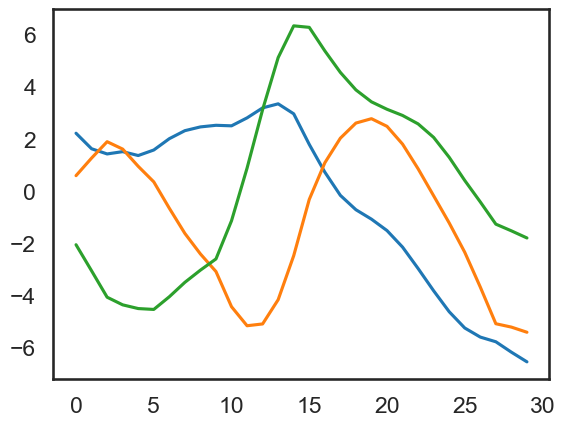

In [31]:
psth=loadmat('/Users/user/PycharmProjects/PacManMain/data/SLDSData/XT2ACC.mat')
Xin=psth['Xt1']
K = 2   # number of discrete states
D = 3 # number of latent dimensions
Xin=Xin.transpose()
N = Xin.shape[1]     # number of observed dimensions

slds = ssm.SLDS(N, K, D,dynamics="gaussian",transitions="recurrent_only",emissions="gaussian")
slds.dynamics.l2_penalty_A=1e-08
slds.initialize(Xin)
q_lem_elbos, q_lem = slds.fit(Xin,
                                 method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=20,  alpha=0)

q_lem_x = q_lem.mean_continuous_states[0]



# Find the permutation that matches the true and inferred states
q_lem_z = slds.most_likely_states(q_lem_x, Xin)

#ax = plt.figure().add_subplot(projection='3d')
#ax.plot(q_lem_x[:,0],q_lem_x[:,1],q_lem_x[:,2])

plt.plot(q_lem_x)



elbs,pots=slds.approximate_posterior(Xin)

ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -13598.0: 100%|██████████| 100/100 [00:02<00:00, 36.71it/s]


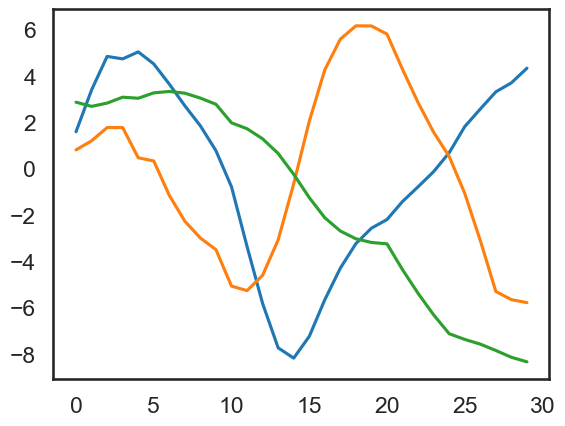

In [32]:
psth=loadmat('/Users/user/PycharmProjects/PacManMain/data/SwitchPSTH/PSTH_ACC_ALL_P1.mat')
Xin=psth['Xt']
K = 2   # number of discrete states
D = 3 # number of latent dimensions
N = Xin.shape[1]     # number of observed dimensions

slds = ssm.SLDS(N, K, 3,dynamics="gaussian",transitions="recurrent_only",emissions="gaussian")
slds.dynamics.l2_penalty_A=1e-08
slds.initialize(Xin)
q_lem_elbos, q_lem = slds.fit(Xin,
                                 method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=800,  alpha=0)

q_lem_x = q_lem.mean_continuous_states[0]



# Find the permutation that matches the true and inferred states
q_lem_z = slds.most_likely_states(q_lem_x, Xin)

#ax = plt.figure().add_subplot(projection='3d')
#ax.plot(q_lem_x[:,0],q_lem_x[:,1],q_lem_x[:,2])

plt.plot(q_lem_x)



elbs,pots=slds.approximate_posterior(Xin)

In [28]:
psth=loadmat('/Users/user/PycharmProjects/PacManMain/data/SwitchPSTH/PSTH_ACC_ALL_P1.mat')
Xin=psth['Xt']
Xinlist=[]
Xinlist.append(Xin)

psth=loadmat('/Users/user/PycharmProjects/PacManMain/data/SwitchPSTH/PSTH_ACC_ALL_P2.mat')
Xin=psth['Xt']
Xinlist.append(Xin)



K = 2   # number of discrete states
D = 3 # number of latent dimensions
N = Xin.shape[1]     # number of observed dimensions

slds = ssm.SLDS(N, K, 3,dynamics="gaussian",transitions="recurrent_only",emissions="gaussian")
slds.dynamics.l2_penalty_A=1e-08
slds.initialize(Xinlist)
q_lem_elbos, q_lem = slds.fit(Xinlist,
                                 method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=800,  alpha=0)





ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: 15185.0: 100%|██████████| 800/800 [00:45<00:00, 17.48it/s]


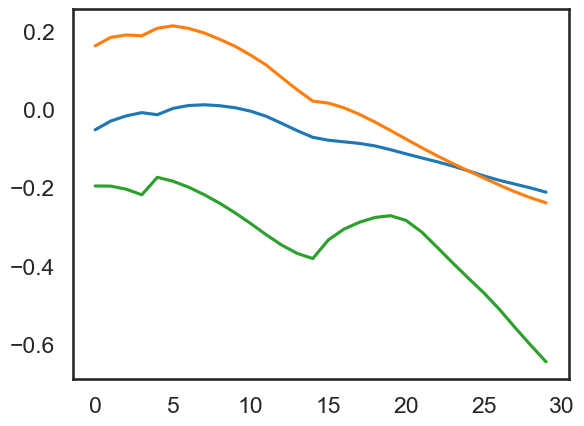

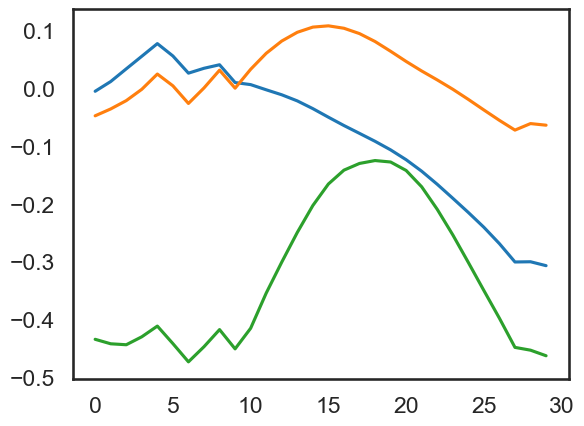

In [29]:
plt.plot(q_lem.mean_continuous_states[0])
plt.show()
plt.plot(q_lem.mean_continuous_states[1])
plt.show()



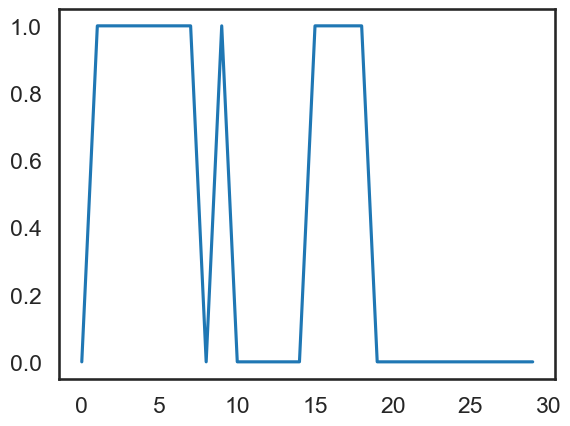

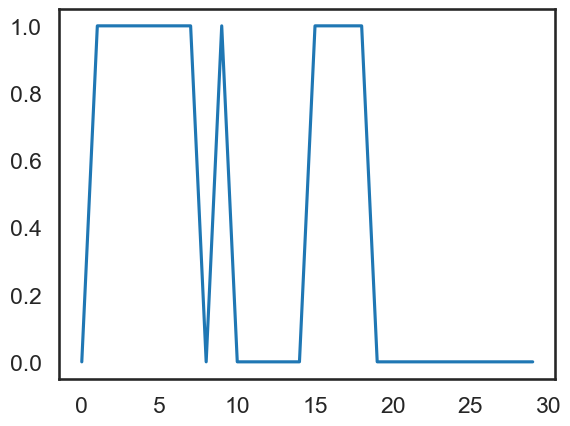

In [25]:
q_lem_z = slds.most_likely_states(q_lem_x, Xinlist[0])
plt.plot(q_lem_z)
plt.show()
q_lem_z = slds.most_likely_states(q_lem_x, Xinlist[1])
plt.plot(q_lem_z)
plt.show()


ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: 769.1: 100%|██████████| 100/100 [00:06<00:00, 14.70it/s]


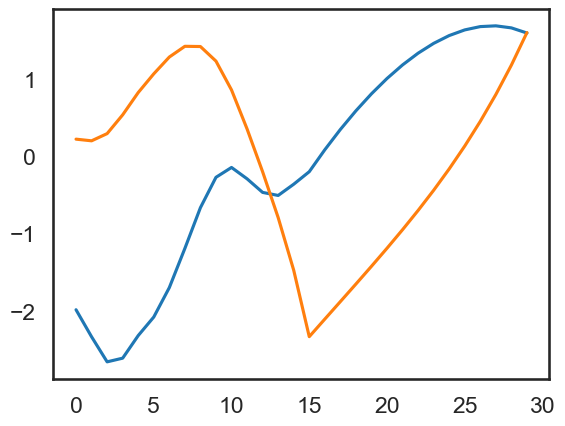

In [6]:
psth=loadmat('/Users/user/PycharmProjects/PacManMain/data/SwitchPSTH/PSTH_ACC_ALL_P1.mat')
P1=psth['Xt'][:,0,:].transpose()
P2=psth['Xt'][:,1,:].transpose()
P1=P1.mean(axis=1)
P2=P2.mean(axis=1)

rmlist1=np.where((P1.mean(axis=0)==0))[0].tolist()
rmlist2=np.where((P2.mean(axis=0)==0))[0].tolist()
rmlist=rmlist1+rmlist2

P1 = np.delete(P1, rmlist, axis=1)
P2 = np.delete(P2, rmlist, axis=1)


P1=(P1/(P1.max(axis=0)-P1.min(axis=0))+5)
P1=P1-P1.mean(axis=0)

#Remove temporal grand mean
P1=(P1.transpose()-P1.mean(axis=1)).transpose()

P2=(P2/(P2.max(axis=0)-P2.min(axis=0))+5)
P2=P2-P2.mean(axis=0)
P2=(P2.transpose()-P2.mean(axis=1)).transpose()


#For z-score
#P1=stats.zscore(P1,axis=0)
#P2=stats.zscore(P2,axis=0)

Xin=P1

K = 2   # number of discrete states
D = 3 # number of latent dimensions
N = Xin.shape[1]     # number of observed dimensions

slds = ssm.SLDS(N, K, 3,dynamics="gaussian",transitions="recurrent_only",emissions="gaussian")
slds.dynamics.l2_penalty_A=1e-08
slds.initialize(Xin)
q_lem_elbos, q_lem = slds.fit(Xin,
                                 method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=800,  alpha=0)

q_lem_x = q_lem.mean_continuous_states[0]



# Find the permutation that matches the true and inferred states
q_lem_z = slds.most_likely_states(q_lem_x, Xin)

#ax = plt.figure().add_subplot(projection='3d')
#ax.plot(q_lem_x[:,0],q_lem_x[:,1],q_lem_x[:,2])

plt.plot(q_lem_x)



elbs,pots=slds.approximate_posterior(Xin)



Text(0.5, 1.0, 'Inferred Dynamics, Laplace-EM')

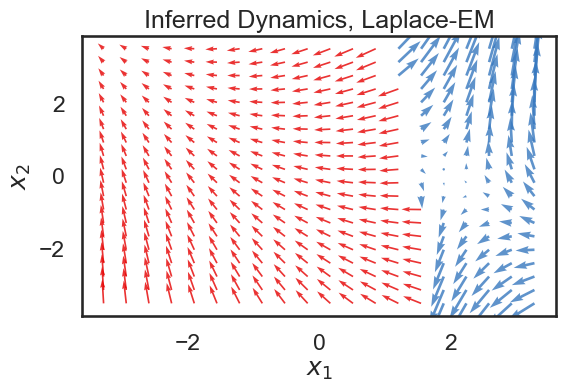

In [18]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(q_lem_x).max(axis=0) + 1
plot_most_likely_dynamics(slds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, Laplace-EM")

<Figure size 500x500 with 0 Axes>

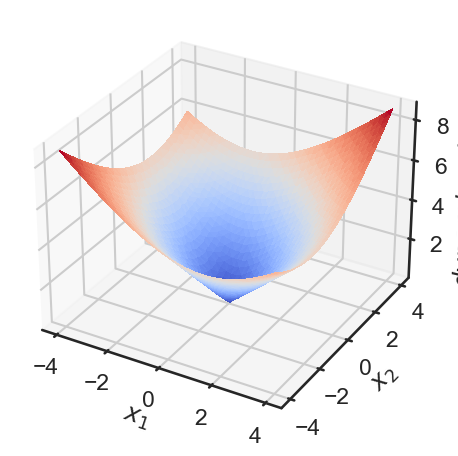

In [12]:
from matplotlib import cm

model = slds
xlim=(-4, 4)
ylim=(-4, 4)
nxpts=40
nypts=40
alpha=0.8
ax=None
figsize=(5, 5)

# Create a grid of x, y values
x = np.linspace(*xlim, nxpts)
y = np.linspace(*ylim, nypts)
X, Y = np.meshgrid(x, y)
xy = np.column_stack((X.ravel(), Y.ravel()))

if ax is None:
    fig = plt.figure(figsize=figsize)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

dxydt_m = (xy).dot((model.dynamics.As).T)
dxydt_m_norm = np.zeros((len(dxydt_m)))

for xt in range(0,len(dxydt_m)):
    dxydt_m_norm[xt] = np.linalg.norm(dxydt_m[xt,:])

ax.plot_trisurf(xy[:, 0], xy[:, 1], dxydt_m_norm, cmap=cm.coolwarm,
              linewidth=0, antialiased=False)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$ dynamic velocity$')

plt.tight_layout()

In [9]:
psth=loadmat('/Users/user/PycharmProjects/PacManMain/data/SwitchPSTH/PSTH_3_P2.mat')
Xrange=(psth['Xt'][:,:,:].mean(axis=2).max(axis=0)-psth['Xt'][:,:,:].mean(axis=2).min(axis=0))+5

#grand mean
Gm=psth['Xt'].mean(axis=2).mean(axis=0)
for i in range(psth['Xt'].shape[2]):
    psth['Xt'][:,:,i]=(psth['Xt'][:,:,i]/Xrange)-Gm

psth=psth['Xt']

#remove grand mean time series too

psth=(psth[:,:,:].transpose()-psth.mean(axis=1).mean(axis=1)).transpose()



#psth=psth.mean(axis=2)

K = 2   # number of discrete states
D = 3   # number of latent dimensions
N = psth.shape[1]     # number of observed dimensions

psth = [psth[:, :, i] for i in range(psth.shape[2])]
psth=psth[0:50]
slds = ssm.SLDS(N, K, D,transitions="recurrent_only",emissions="gaussian_orthog")
slds.initialize(psth)
q_lem_elbos, q_lem = slds.fit(psth,
                                 method="laplace_em",
                            variational_posterior="structured_meanfield",
                              num_iters=50,  alpha=0)

X_lem=[]
for i in range(50):
    X_lem.append(q_lem.mean_continuous_states[i])

X_lem=np.stack(X_lem)

ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ELBO: -173549.7: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


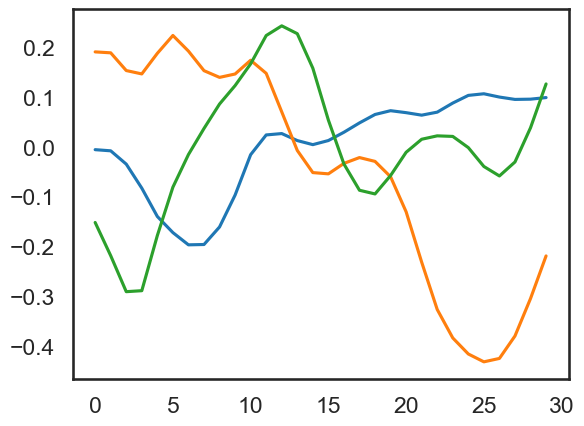

In [11]:
plt.plot(X_lem.mean(axis=0))
plt.show()
X_lem.shape

In [56]:
#QWe may need to fuck with emissions for positivty and fit method.

In [1]:
#rSLDS settings
K = 2   # number of discrete states
D = 3       # number of latent dimensions
N = nunits     # number of observed dimensions

print("Fitting SLDS with BBVI")
slds = ssm.SLDS(N, K, D, emissions="gaussian")
slds.initialize(testtrial)
q_lem_elbos, q_lem = slds.fit(testtrial,
                                 method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=800, initialize=False, alpha=0)




NameError: name 'nunits' is not defined

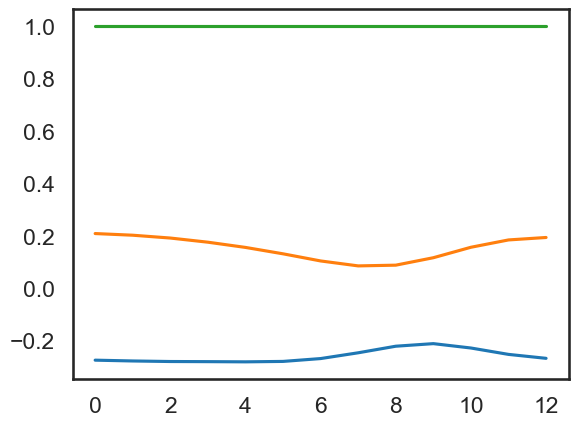

In [60]:
q_lem_x = q_lem.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
q_lem_z = slds.most_likely_states(q_lem_x, testtrial)

# Smooth the data under the variational posterior
q_lem_y = slds.smooth(q_lem_x, testtrial)
plt.plot(q_lem_x)
plt.plot(q_lem_z)

/Users/user/anaconda3/envs/main/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

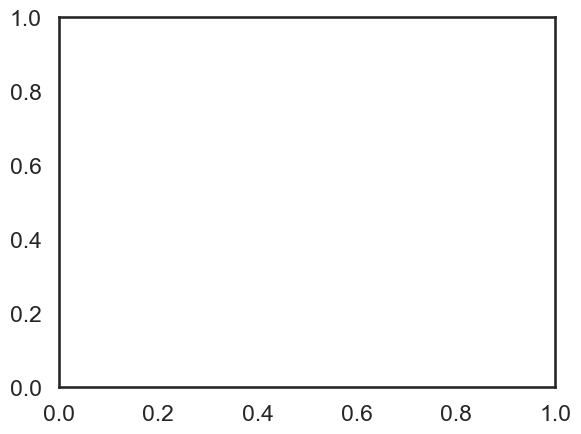

In [13]:
slds = ssm.SLDS(N, K, D, emissions="gaussian")

slds.initialize(testtrial)


q_lem_elbos, q_lem = slds.fit(testtrial,  method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=300, initialize=True, alpha=0)

ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.



ARHMM Initialization restarts: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


AssertionError: 

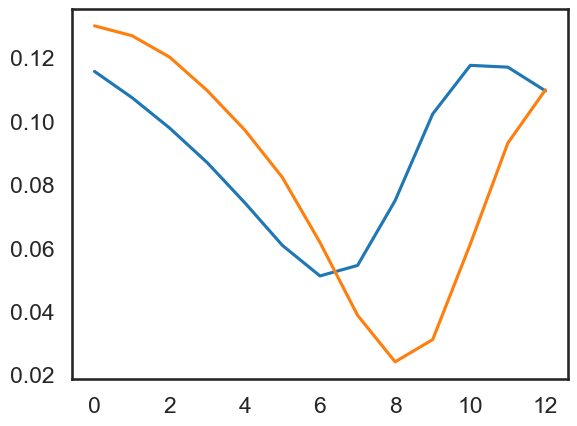

In [12]:
q_lem_x = q_lem.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
q_lem_z = slds.most_likely_states(q_lem_x, testtrial)

# Smooth the data under the variational posterior
q_lem_y = slds.smooth(q_lem_x, testtrial)
plt.plot(q_lem_x)

In [9]:
# Set the parameters of the SLDS
T = 1000    # number of time bins
K = 5       # number of discrete states
D = 2       # number of latent dimensions
N = 100     # number of observed dimensions

# Make an SLDS with the true parameters
true_slds = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))

# Set rotational dynamics
for k in range(K):
    true_slds.dynamics.As[k] = .95 * random_rotation(D, theta=(k+1) * np.pi/20)
    true_slds.dynamics.bs[k] = 3 * npr.randn(D)

# Set an offset to make the counts larger
# true_slds.emissions.ds += 10

# Sample data
z, x, y = true_slds.sample(T)


In [10]:
mask = npr.rand(T, N) < 0.95
y_masked = y * mask

In [21]:
print("Fitting SLDS with BBVI")
slds = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
slds.initialize(y_masked, masks=mask)

Fitting SLDS with BBVI


In [ ]:
q_bbvi_elbos, q_bbvi = slds.fit(y_masked, masks=mask, method="bbvi",
                              variational_posterior="tridiag",
                              initial_variance=1,
                              num_iters=1000, print_intvl=100, initialize=False)

ELBO: -102517.4:  48%|████▊     | 476/1000 [00:23<00:29, 17.85it/s]

In [11]:
y_masked.dtype

dtype('int64')